In [340]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from scipy.integrate import odeint
from matplotlib.ticker import FormatStrFormatter

In [215]:
def RosenzweigMacArthur(x, t, h2):
    c1 = 5.0
    h1 = 3.0
    c2 = 0.1
    m2 = 0.4
    m3 = 0.008
    
    dx = x[0]*(1-x[0]) - c1 * x[0] * x[1] / (1.0 + h1*x[0])
    dy = c1 * x[0] * x[1] / (1.0 + h1 * x[0]) - c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m2*x[1]
    dz = c2 * x[1] * x[2] / (1.0 + h2(t) * x[1]) - m3 * x[2]

    return (dx, dy, dz)

def Lorenz96P(x, t, F):
    N = 5 # dimension

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F(t)
    return d

In [216]:
def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

def delayEmbed(Xin, Yin,assignment,embInterval):
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            lag = 1
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    return (Xin, Yin)

In [363]:
settlingTime = 5

end = 2**10
tlen = 2 ** 16 + settlingTime
reduction = 2 ** 9
trainToTest = 0.80 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1
# t0 = np.array([0.5])
# t0 = np.ones(dim) * 0.3333# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0 = np.array([0.8,0.1,9])
# t0 = np.ones(3)
t0[0] += 0.1

In [364]:
# Density Dependent Maturation
"""
states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

Xr = standardize(states[settlingTime:,0,None])
print(Xr.shape)
"""

# Rosenzweig MacArthur
h2 = lambda t : 2.0 - 1.0 * t / end

Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::reduction,0,None]
# Xr = standardize(odeint(RosenzweigMacArthur, t0, t, args=(h2,)))[::reduction,:]

"""
# Lorenz 96
# F = lambda t : 7 + 10 * t / end
F = lambda t : 12 + 5 * np.sin(2 * np.pi * t / end)

Xr = standardize(odeint(Lorenz96P, t0, t, args=(F,)))[::reduction,0,None]
"""

'\n# Lorenz 96\n# F = lambda t : 7 + 10 * t / end\nF = lambda t : 12 + 5 * np.sin(2 * np.pi * t / end)\n\nXr = standardize(odeint(Lorenz96P, t0, t, args=(F,)))[::reduction,0,None]\n'

In [365]:
""" UPDATE DRIVERS HERE """

digiDrivers = [h2]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
gtsr = h2(t) # driverArray

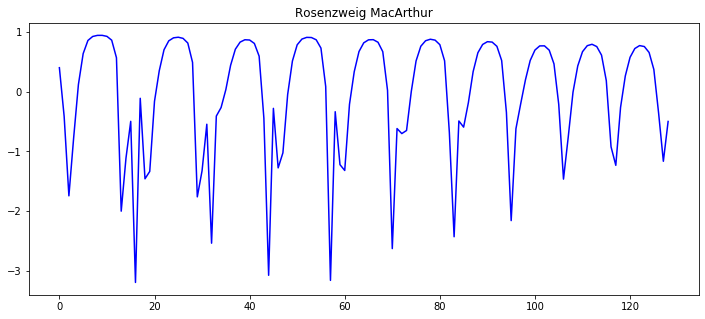

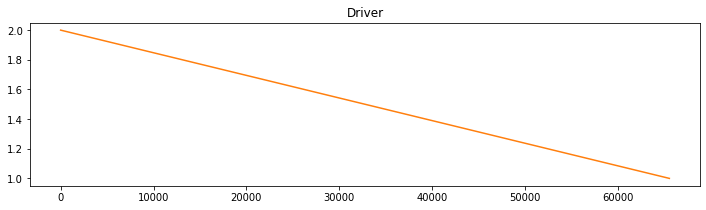

In [367]:
fig2 = plt.figure(2,figsize=(12,5))

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [368]:
predictionStep = 1
X, Y = delayEmbed(Xr[:-predictionStep],Xr[predictionStep:],[12],1)

testTrainSplit = int(Xr.shape[0] * trainToTest)
Xtrain = X[:testTrainSplit]
Ytrain = Y[:testTrainSplit]
Xtest = X[testTrainSplit:]
Ytest = Y[testTrainSplit:]

[-0.68843563]


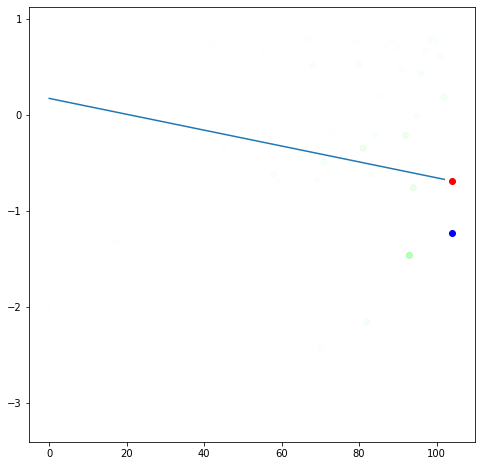

In [369]:
i = 1
pred = Xtest[i]
predTime = Xtrain.shape[0] + i

theta = 2 ** 2

# print(predTime - np.arange(0,Xtrain.shape[0]))
delta = 2 ** -5

norms = la.norm(pred - Xtrain,axis=1)
d = np.mean(norms)
weights = np.exp(-1*theta*la.norm(pred - Xtrain,axis=1)/d - delta * (predTime - np.arange(0,Xtrain.shape[0])))
weights = np.reshape(weights,(weights.shape[0],1))

np.set_printoptions(suppress=True)

A = np.hstack((np.arange(Ytrain.shape[0]).reshape((Ytrain.shape[0],1)), np.multiply(Ytrain,weights)))
tmean = np.dot(A[:,0],weights)/np.sum(weights)
amean = np.sum(A[:,1])/np.sum(weights)

slope = np.dot(A[:,1] - amean, A[:,0] - tmean) / np.dot(A[:,0] - tmean, A[:,0] - tmean)
intercept = amean - slope * tmean

lineOfBestFit = lambda t : intercept + slope * t

prediction = lineOfBestFit(predTime)

print(prediction)

# kernel = np.fromfunction(lambda i,j: np.exp(-1*la.norm(X[i]-X[j],axis=2)) , (X.shape[0],X.shape[0]),dtype=int)

figKernel, axKernel = plt.subplots(1, figsize=(8,8))
colors = np.zeros((Xtrain.shape[0],4))
colors[:,1] = 1
colors[:,3,None] = weights
axKernel.scatter(np.arange(Ytrain.shape[0]),Ytrain,c=colors)
axKernel.plot(np.arange(Ytrain.shape[0]), lineOfBestFit(np.arange(Ytrain.shape[0])))
axKernel.scatter(predTime, prediction, c="red")
axKernel.scatter(predTime, Ytest[i], c="blue")
# plt.ylim([-0.25,0.5])
# axKernel[1].scatter(A[:,0],A[:,1])
# axKernel[1].scatter(np.arange(Ytrain.shape[0]),np.arange(Ytrain.shape[0])*V[0,0])
# axKernel.imshow(kernel)
plt.show()

In [370]:
# SMap
def nearestNeighbors(state, n):
    orderedNeighbors = sorted(range(len(trainStates)-1), key = lambda i : la.norm(state - trainStates[i]), reverse=False)
    return orderedNeighbors[:n]

def nearestNeighborsPrediction(state):
    neighborIndexes = nearestNeighbors(state, numNeighbors)
    pred1neigh = list(map(lambda i: trainStates[i+1], neighborIndexes))
    return sum(pred1neigh) / numNeighbors

# make a 1 time step prediction based on a given state(nD vector)
def SMap(X, Y, x, theta, d):
    W = getWeightedValues(x, X, theta, d)
    # print(X.shape, np.diag(W).shape, Y.shape)
    H = la.inv(np.transpose(X) @ np.diag(W) @ X) @ np.transpose(X) @ np.diag(W) @ Y
    return x @ H

def getWeightedValues(state, states, theta, d):
    # calculate weights for each element
    return np.exp(-1 * theta * la.norm(states-state,axis=1) / d)
    """
    weights = np.zeros(states.shape[0])
    current = np.array(state)
    for i, elem in enumerate(states):
        diff = current - elem
        norm = la.norm(diff)
        exponent = -1 * theta * norm / d
        weights[i] = np.exp(exponent)
    return weights
    """
    
def calculateD(states):
    return np.mean(np.fromfunction(lambda i,j: la.norm(states[i]-states[j]),(states.shape[1],states.shape[1]),dtype=int))

def GMap(X, Y, T, x, t, theta, delta):
    # print(X, Y, T, x, t)
    # include time as a state variable
    norms = la.norm(x - X,axis=1)
   
    # create weights
    d = np.mean(norms)
    weights = np.exp(-1*theta*norms/d - delta*np.absolute(t-T))
    weights = np.reshape(weights,(weights.shape[0],1))
    
    # create matrices
    W = np.diag(np.sqrt(weights.flatten()))
    T = T.reshape((T.shape[0],1))
    M = np.hstack([np.ones(T.shape), X, T])
    
    params = la.inv((W@M).T @ (W@M)) @ (W@M).T @ (W@Y)
    
    xaug = np.hstack([1, x, t])
    prediction = np.dot(xaug, params)
    
    return prediction

In [371]:
theta = 10
delta = 2 ** -6

peepee = GMap(Xtrain, Ytrain, t[:Xtrain.shape[0]], Xtest[0], t[testTrainSplit], theta, delta)
print("Truth ", Ytest[0])
print("GMAP ", peepee)
print("SMAP ", SMap(Xtrain, Ytrain, Xtest[0], theta, d)[0])

Truth  [-0.92237992]
GMAP  [-0.61364495]
SMAP  -0.6309027051430662


In [372]:
i = 0
p = Xtest[0]
time = Xtrain.shape[0] + i

# prediction = GMap(Xtrain, Ytrain, p, time, 10)

d = calculateD(Xtrain)

predictionsGMap = np.zeros((Xtest.shape[0]))
predictionsSMap = np.zeros((Xtest.shape[0]))
# predictionsGMapSD = np.zeros((Xtest.shape[0]))
for i in range(Xtest.shape[0]):
    # predictionsGMap[i] = GMap(Xtrain, Ytrain, Xtest[i], Xtrain.shape[0] + i, 30)
    predictionsSMap[i] = SMap(Xtrain, Ytrain, Xtest[i], 30, d)[0]
    predictionsGMap[i] = GMap(Xtrain, Ytrain, t[:testTrainSplit], Xtest[i], t[testTrainSplit+i], 30, Xtrain.shape[0] ** -1)

In [373]:
# steps ahead prediction

GMap MSE  0.943681238666231
SMap MSE  4.151278748321411
Improvement  4.39902647019739


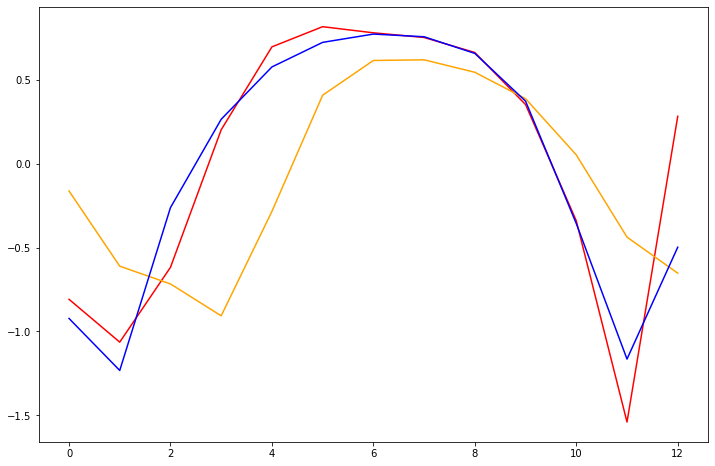

In [374]:
# print(np.dot(Ytest - predictionsGMap,Ytest - predictionsGMap))
# print(np.dot(Ytest - predictionsSMap,Ytest - predictionsSMap))

MSEG = np.dot(Ytest.flatten() - predictionsGMap,Ytest.flatten() - predictionsGMap)
MSES = np.dot(Ytest.flatten() - predictionsSMap,Ytest.flatten() - predictionsSMap)

print("GMap MSE ",MSEG)
print("SMap MSE ",MSES)
print("Improvement ", MSES / MSEG)

figGMap, axGMap = plt.subplots(1, figsize = (12,8))
axGMap.plot(predictionsGMap, c="red")
axGMap.plot(predictionsSMap, c="orange")
axGMap.plot(Ytest, c="blue")
plt.show()

In [382]:
theta = 2 ** 2
delta = 0

thetaFunc = lambda i : 1.45 ** (i)
deltaFunc = lambda i : ((i-4) / 2) ** 3

# n Timesteps 
maxPredictionHorizon = 2
nTrials = 10

embdim = 13

X, te = delayEmbed(Xr, t, [embdim],1)
Y = X[:,0]

timestepPredictionsGMap = np.zeros((nTrials, maxPredictionHorizon))
timestepPredictionsSMap = np.zeros((nTrials, maxPredictionHorizon))

GMapPredictedTimeSeries = np.zeros((nTrials, maxPredictionHorizon))
SMapPredictedTimeSeries = np.zeros((nTrials, maxPredictionHorizon))
TrueTimeSeries = np.zeros(nTrials)

nHPvals = 15
errThetaSMap = np.ones((nHPvals,))
errThetaDeltaGMap = np.ones((nHPvals, nHPvals))

for thetaexp in range(nHPvals):
    theta = thetaFunc(thetaexp)
    # theta = 194
    for i in range(nTrials):
        for j in range(1,maxPredictionHorizon+1):    
            # j is prediction stepsize
            # Xj and Yj are X and Y with j step prediction
            Xj = X[:-j]
            Yj = Y[j:]
            tXj = te[:-j]
            tYj = te[j:]

            # this is the cutoff between training and testing data
            startIndex = Xj.shape[0] - i - maxPredictionHorizon

            # create the train and test stuff
            Xjtr = Xj[:startIndex]
            Yjtr = Yj[:startIndex]
            tXjtr = tXj[:startIndex]
            tYjtr = tYj[:startIndex]

            Xjts = Xj[startIndex]
            Yjts = Yj[startIndex]
            tXjts = tYj[startIndex]
            tYjts = tYj[startIndex]

            d = calculateD(Xjtr)

            predictionSMap = SMap(Xjtr, Yjtr, Xjts, theta, d)

            SMapPredictedTimeSeries[i,j-1] = predictionSMap
            TrueTimeSeries[i] = Yjts

            timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

    errThetaSMap[thetaexp] = np.mean(timestepPredictionsSMap)
print("Done wit SMap")

# theta = 7.59
# delta = 8
for thetaexp in range(nHPvals-3):
     for deltaexp in range(nHPvals):
        theta = thetaFunc(thetaexp)
        delta = deltaFunc(deltaexp)
        for i in range(nTrials):
            for j in range(1,maxPredictionHorizon+1):    
                # j is prediction stepsize
                # Xj and Yj are X and Y with j step prediction
                Xj = X[:-j]
                Yj = Y[j:]
                tXj = te[:-j]
                tYj = te[j:]

                # this is the cutoff between training and testing data
                startIndex = Xj.shape[0] - i - maxPredictionHorizon

                # create the train and test stuff
                Xjtr = Xj[:startIndex]
                Yjtr = Yj[:startIndex]
                tXjtr = tXj[:startIndex]
                tYjtr = tYj[:startIndex]

                Xjts = Xj[startIndex]
                Yjts = Yj[startIndex]
                tXjts = tYj[startIndex]
                tYjts = tYj[startIndex]

                d = calculateD(Xjtr)

                predictionGMap = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta)

                GMapPredictedTimeSeries[i,j-1] = predictionGMap
                TrueTimeSeries[i] = Yjts

                # timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)
                # timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

                timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)

        errThetaDeltaGMap[thetaexp, deltaexp] = np.mean(timestepPredictionsGMap)
        print(f"Theta = {theta} Delta = {delta} Error = {errThetaDeltaGMap[thetaexp, deltaexp]}")


Done wit SMap
Theta = 1.0 Delta = -8.0 Error = 0.8496087325650118
Theta = 1.0 Delta = -3.375 Error = 0.5380612903400486
Theta = 1.0 Delta = -1.0 Error = 0.36707295911513804
Theta = 1.0 Delta = -0.125 Error = 0.30724507467874507
Theta = 1.0 Delta = 0.0 Error = 0.2997739371075902
Theta = 1.0 Delta = 0.125 Error = 0.29229162776202616
Theta = 1.0 Delta = 1.0 Error = 0.24828322158008928
Theta = 1.0 Delta = 3.375 Error = 0.21508490627999527
Theta = 1.0 Delta = 8.0 Error = 0.19383884959656464
Theta = 1.0 Delta = 15.625 Error = 0.1387827286579769
Theta = 1.0 Delta = 27.0 Error = 0.14132171703007493
Theta = 1.0 Delta = 42.875 Error = 0.2013973907943442
Theta = 1.0 Delta = 64.0 Error = 0.6025080225834855
Theta = 1.0 Delta = 91.125 Error = 3.151729140131568
Theta = 1.0 Delta = 125.0 Error = 6.204587031614471
Theta = 1.45 Delta = -8.0 Error = 0.8343727215625305
Theta = 1.45 Delta = -3.375 Error = 0.521751005609404
Theta = 1.45 Delta = -1.0 Error = 0.34411098972171356
Theta = 1.45 Delta = -0.125 Er

Theta = 28.334269484119133 Delta = -8.0 Error = 0.23848652820541388
Theta = 28.334269484119133 Delta = -3.375 Error = 0.2694460576456505
Theta = 28.334269484119133 Delta = -1.0 Error = 0.3054442924852368
Theta = 28.334269484119133 Delta = -0.125 Error = 0.3059632802174672
Theta = 28.334269484119133 Delta = 0.0 Error = 0.30582108016377124
Theta = 28.334269484119133 Delta = 0.125 Error = 0.3056679898688045
Theta = 28.334269484119133 Delta = 1.0 Error = 0.3070910644563699
Theta = 28.334269484119133 Delta = 3.375 Error = 0.3135667087911931
Theta = 28.334269484119133 Delta = 8.0 Error = 0.13191658703265835
Theta = 28.334269484119133 Delta = 15.625 Error = 0.15483840264047652
Theta = 28.334269484119133 Delta = 27.0 Error = 0.15491473783499182
Theta = 28.334269484119133 Delta = 42.875 Error = 0.1246859642842919
Theta = 28.334269484119133 Delta = 64.0 Error = 0.17230985639700255
Theta = 28.334269484119133 Delta = 91.125 Error = 2.7361011970317106
Theta = 28.334269484119133 Delta = 125.0 Error 

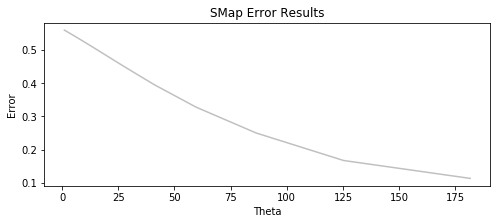

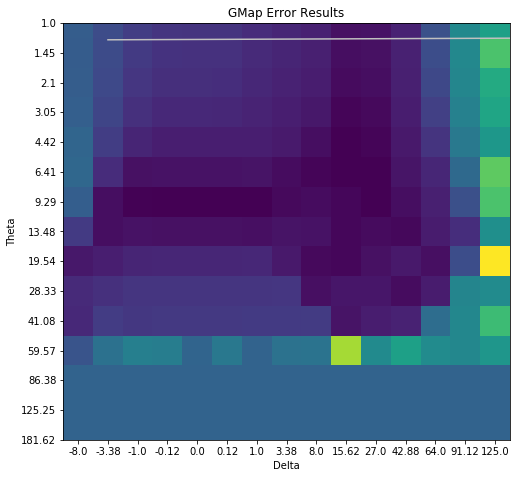

Min SMap Error: 0.1136176244594647, Min GMap Error: 0.09923641632400718
Improvement of GMap: 1.144918656559532


In [383]:
# Theta Optimization
fig1, ax1 = plt.subplots(1, figsize = (8,3))
ax1.plot(thetaFunc(np.arange(nHPvals)), errThetaSMap, c="silver")
ax1.set_title("SMap Error Results")
ax1.set_xlabel("Theta")
ax1.set_ylabel("Error")

fig2, ax2 = plt.subplots(1, figsize = (8,8))
ax2.plot(thetaFunc(np.arange(nHPvals)), errThetaSMap, c="silver")
ax2.imshow(np.log(errThetaDeltaGMap))
ax2.set_xticks(range(nHPvals))
ax2.set_xticklabels(list(np.round(deltaFunc(np.arange(nHPvals)),2)))
ax2.set_xlabel("Delta")
ax2.set_yticks(np.arange(nHPvals))
ax2.set_yticklabels(list(np.round(thetaFunc(np.arange(nHPvals)),2)))
ax2.set_ylabel("Theta")
ax2.set_title("GMap Error Results")
plt.show()

print(f"Min SMap Error: {np.min(errThetaSMap)}, Min GMap Error: {np.min(errThetaDeltaGMap)}")
print(f"Improvement of GMap: {np.min(errThetaSMap)/np.min(errThetaDeltaGMap)}")

In [387]:
theta = 2 ** 2
delta = 0

thetaFunc = lambda i : 1.45 ** (i)
deltaFunc = lambda i : ((i-4) / 2) ** 3

# n Timesteps 
maxPredictionHorizon = 2
nTrials = 10

embdim = 13

X, te = delayEmbed(Xr, t, [embdim],1)
Y = X[:,0]

timestepPredictionsGMap = np.zeros((nTrials, maxPredictionHorizon))
timestepPredictionsSMap = np.zeros((nTrials, maxPredictionHorizon))

GMapPredictedTimeSeries = np.zeros((nTrials, maxPredictionHorizon))
SMapPredictedTimeSeries = np.zeros((nTrials, maxPredictionHorizon))
TrueTimeSeries = np.zeros(nTrials)

theta = 194
for i in range(nTrials):
    for j in range(1,maxPredictionHorizon+1):    
        # j is prediction stepsize
        # Xj and Yj are X and Y with j step prediction
        Xj = X[:-j]
        Yj = Y[j:]
        tXj = te[:-j]
        tYj = te[j:]

        # this is the cutoff between training and testing data
        startIndex = Xj.shape[0] - i - maxPredictionHorizon

        # create the train and test stuff
        Xjtr = Xj[:startIndex]
        Yjtr = Yj[:startIndex]
        tXjtr = tXj[:startIndex]
        tYjtr = tYj[:startIndex]

        Xjts = Xj[startIndex]
        Yjts = Yj[startIndex]
        tXjts = tYj[startIndex]
        tYjts = tYj[startIndex]

        d = calculateD(Xjtr)

        predictionSMap = SMap(Xjtr, Yjtr, Xjts, theta, d)

        SMapPredictedTimeSeries[i,j-1] = predictionSMap
        TrueTimeSeries[i] = Yjts

        timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

print("Done wit SMap")

theta = 9.3
delta = 0
for i in range(nTrials):
    for j in range(1,maxPredictionHorizon+1):    
        # j is prediction stepsize
        # Xj and Yj are X and Y with j step prediction
        Xj = X[:-j]
        Yj = Y[j:]
        tXj = te[:-j]
        tYj = te[j:]

        # this is the cutoff between training and testing data
        startIndex = Xj.shape[0] - i - maxPredictionHorizon

        # create the train and test stuff
        Xjtr = Xj[:startIndex]
        Yjtr = Yj[:startIndex]
        tXjtr = tXj[:startIndex]
        tYjtr = tYj[:startIndex]

        Xjts = Xj[startIndex]
        Yjts = Yj[startIndex]
        tXjts = tYj[startIndex]
        tYjts = tYj[startIndex]

        d = calculateD(Xjtr)

        predictionGMap = GMap(Xjtr, Yjtr, tXjtr, Xjts, tXjts, theta, delta)

        GMapPredictedTimeSeries[i,j-1] = predictionGMap
        TrueTimeSeries[i] = Yjts

        # timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)
        # timestepPredictionsSMap[i,j-1] = abs(predictionSMap - Yjts)

        timestepPredictionsGMap[i,j-1] = abs(predictionGMap - Yjts)

Done wit SMap


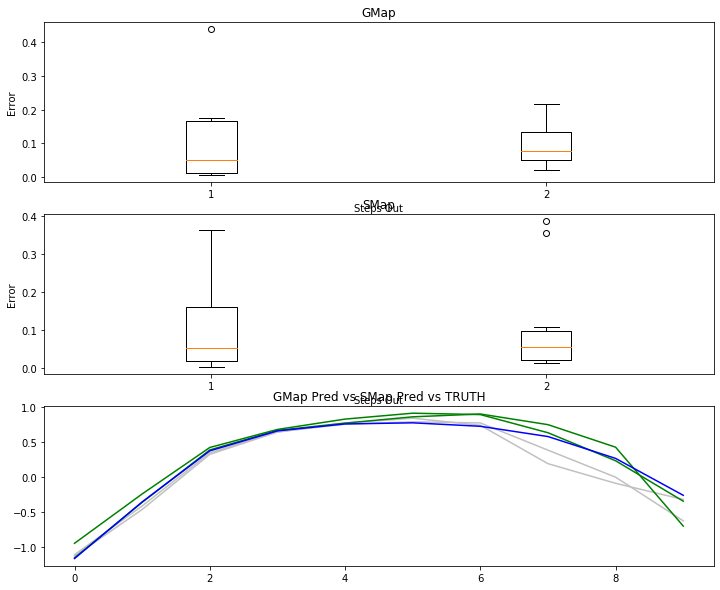

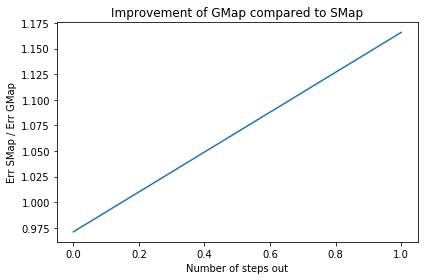

In [388]:
figTS, axTS = plt.subplots(3, figsize=(12,10))
axTS[0].boxplot(timestepPredictionsGMap)
axTS[0].set_title("GMap")
axTS[0].set_ylabel("Error")
axTS[0].set_xlabel("Steps Out")
axTS[1].boxplot(timestepPredictionsSMap)
axTS[1].set_title("SMap")
axTS[1].set_ylabel("Error")
axTS[1].set_xlabel("Steps Out")
axTS[2].set_title("GMap Pred vs SMap Pred vs TRUTH")
axTS[2].plot(SMapPredictedTimeSeries, c="silver")
axTS[2].plot(GMapPredictedTimeSeries, c="green")
axTS[2].plot(TrueTimeSeries, c="blue")
    
figD, axD = plt.subplots(1)
axD.plot(np.mean(timestepPredictionsSMap,axis=0) / np.mean(timestepPredictionsGMap, axis=0))
axD.set_title("Improvement of GMap compared to SMap")
axD.set_xlabel("Number of steps out")
axD.set_ylabel("Err SMap / Err GMap")
    
"""
figPP, axPP = plt.subplots(3, figsize=(12,10))
axPP[0].plot(timestepPredictionsGMap)
axPP[1].plot(timestepPredictionsSMap)
axPP[2].plot(Xr[-nTrials:])
"""
plt.tight_layout()
plt.show()

In [ ]:
"""
Note: just got the result that GMap improves predictablility in the case of a Lorenz system at from between
1 to 4 and 7+ steps ahead, which is counterintuitive. It should be that in the low step case, little
nonstationary signal is going to effect the results, so SMap will do better, while at the extrema, GMap
will likely overextrapolate. But it seems that GMap is doing better in the near and longer term without regard
for the intermediate. Strange.

Also the time series should be moderately smooth for this to have any hope of working
"""